In [1]:
#https://gymnasium.farama.org/environments/atari/
#pip install gymnasium[atari]
#pip install gymnasium[accept-rom-license]
#pip install moviepy
#https://www.youtube.com/watch?v=hCeJeq8U0lo&t=447s
import gymnasium as gym
import random

#image preprocessing
from PIL import Image, ImageStat
from gymnasium.core import ObservationWrapper
from gymnasium.spaces.box import Box
import numpy as np

#n-step
from collections import namedtuple, deque

#deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#enviornment monitoring
from gymnasium.wrappers import RecordVideo

import matplotlib.pyplot as plt

## Deep Q-Learning Agent

### Image Preprocessing

In [2]:
class PreprocessImage(ObservationWrapper):
    
    def __init__(self, env, height = 64, width = 64, grayscale = True, crop = lambda img: img):
        super(PreprocessImage, self).__init__(env)
        self.img_size = (height, width)
        self.grayscale = grayscale
        self.crop = crop
        n_colors = 1 if self.grayscale else 3
        self.observation_space = Box(0.0, 1.0, [n_colors, height, width])

    def observation(self, img):
        img = self.crop(img)
        #img = imresize(img, self.img_size) #deprecated 
        img = Image.fromarray(img)
        img.resize(self.img_size)
        if self.grayscale:
            img = img.convert('L')  # Convert to grayscale
        else:
            img = img.convert('RGB')  # Convert to RGB if necessary
        img = np.array(img)
        if img.ndim == 2:  # Add channel dimension if missing
            img = np.expand_dims(img, axis=2)
        img = np.transpose(img, (2, 0, 1))
        img = img.astype('float32') / 255.
        return img

### N-Step

In [3]:
Step = namedtuple('Step', ['state', 'action', 'reward', 'done'])
class NStepProgress:
    
    def __init__(self, env, ai, n_step):
        self.ai = ai
        self.rewards = []
        self.env = env
        self.n_step = n_step
    
    def __iter__(self):
        state = self.env.reset()
        history = deque()
        reward = 0.0
        while True:
            action = self.ai(np.array([state]))[0][0]
            next_state, r, is_done, _ = self.env.step(action)
            reward += r
            history.append(Step(state = state, action = action, reward = r, done = is_done))
            while len(history) > self.n_step + 1:
                history.popleft()
            if len(history) == self.n_step + 1:
                yield tuple(history)
            state = next_state
            if is_done:
                if len(history) > self.n_step + 1:
                    history.popleft()
                while len(history) >= 1:
                    yield tuple(history)
                    history.popleft()
                self.rewards.append(reward)
                reward = 0.0
                state = self.env.reset()
                history.clear()
    
    def rewards_steps(self):
        rewards_steps = self.rewards
        self.rewards = []
        return rewards_steps

### Experience Replay

In [4]:
class ReplayMemory:
    
    def __init__(self, n_steps, capacity = 10000):
        self.capacity = capacity
        self.n_steps = n_steps
        self.n_steps_iter = iter(n_steps)
        self.buffer = deque()

    def sample_batch(self, batch_size): # creates an iterator that returns random batches
        ofs = 0
        vals = list(self.buffer)
        np.random.shuffle(vals)
        while (ofs+1)*batch_size <= len(self.buffer):
            yield vals[ofs*batch_size:(ofs+1)*batch_size]
            ofs += 1

    def run_steps(self, samples):
        while samples > 0:
            entry = next(self.n_steps_iter) # 10 consecutive steps
            self.buffer.append(entry) # we put 200 for the current episode
            samples -= 1
        while len(self.buffer) > self.capacity: # we accumulate no more than the capacity (10000)
            self.buffer.popleft()

### Convelutional Neural Network

In [3]:
class CNN(nn.Module):
    def __init__(self, number_actions):
        super(CNN, self).__init__() # call nn module init
        self.convolution1 = nn.Conv2d(in_channels=1,
                                      out_channels=32,
                                      kernel_size=5)
        self.convolution2 = nn.Conv2d(in_channels=32,
                                      out_channels=32,
                                      kernel_size=3)
        self.convolution3 = nn.Conv2d(in_channels=32,
                                      out_channels=64,
                                      kernel_size=2)
        self.fc1 = nn.Linear(in_features=self.count_neurons((1, 256, 256)),
                             out_features=40)
        self.fc2 = nn.Linear(in_features=40, 
                             out_features=number_actions)

    def count_neurons(self, image_dim):
        x = Variable(torch.rand(1, *image_dim))
        x = F.relu(F.max_pool2d(self.convolution1(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution2(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2))
        return x.data.view(1, -1).size(1)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.convolution1(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution2(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### SoftmaxBody

In [6]:
class Softmax(nn.Module):
    def __init__(self, T):
        super(Softmax, self).__init__()
        self.T = T

    def forward(self, outputs, number_actions=1):
        probs = F.softmax(outputs * self.T)
        actions = probs.multinomial(num_samples=number_actions)
        return actions

### Eligibility Trace

In [7]:
def eligibility_trace(batch, cnn):
    gamma = 0.99
    inputs = []
    targets = []
    for series in batch:
        input = Variable(torch.from_numpy(np.array([series[0].state, series[-1].state], dtype=np.float32)))
        output = cnn(input)
        cumul_reward = 0.0 if series[-1].done else output[1].data.max()
        for step in reversed(series[:-1]):
            cumul_reward = step.reward + gamma * cumul_reward
            state = series[0].state
            target = output[0].data
            target[series[0].action] = cumul_reward
            inputs.append(state)
            targets.append(target)
            return torch.from_numpy(np.array(inputs, dtype = np.float32)), torch.stack(targets)

### Agent (DQN Learning System )

In [8]:
class AI():
    def __init__(self, CNN, SoftMax):
        self.cnn = CNN
        self.softmax = SoftMax

    def __call__(self, inputs):
        input = Variable(torch.from_numpy(np.array(inputs, dtype = np.float32)))
        output = self.cnn(input)
        actions = self.softmax(output)
        return actions.data.numpy()

In [9]:
class MA:
    def __init__(self, size):
        self.list_of_rewards = []
        self.size = size
    def add(self, rewards):
        if isinstance(rewards, list):
            self.list_of_rewards += rewards
        else:
            self.list_of_rewards.append(rewards)
        while len(self.list_of_rewards) > self.size:
            del self.list_of_rewards[0]
    def average(self):
        return np.mean(self.list_of_rewards)

## Atari Simulator Experiment

### 1,000,000 Capacity Size

In [10]:
env = PreprocessImage(gym.make('ALE/SpaceInvaders-v5', render_mode="human"), width = 256, height = 256, grayscale = True)
env = RecordVideo(env, "videos", episode_trigger = lambda x: x % 2 == 0)
number_actions = env.action_space.n

d:\Projects\repos\tu060\venv_research\lib\site-packages\gymnasium\wrappers\record_video.py:87: UserWarning: WARN: Overwriting existing videos at d:\Projects\repos\tu060\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


#### Create Agent

In [11]:
cnn = CNN(number_actions)
softmax = Softmax(T = 1.0)
ai = AI(CNN=cnn, SoftMax=softmax)
n_steps = NStepProgress(env=env, ai=ai, n_step=10)
memory = ReplayMemory(n_steps=n_steps, capacity=10000)
ma = MA(100) #moving average
loss = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)

#### Simulate the environment

```
episodes = 20
for episode in range(episodes):
    #state = env.reset()
    #done = False
    #score = 0

    #while not done:
    #    env.render()
    #    action = random.choice([0,1,2,3,4,5])
    #    observation, reward, terminated, truncated, info = env.step(action)
    #    score +=reward
    #    done = terminated or truncated
    #print("episode: " + str(episode) + ", score: " + str(score))
    #env.close()

    memory.run_steps(samples=200)
    for batch in memory.sample_batch(128):
        inputs, targets = eligibility_trace(batch)
        inputs, targets = Variable(inputs), Variable(targets)
        predictions = cnn(inputs)
        loss_error = loss(predictions, targets)
        optimizer.zero_grad()
        loss_error.backward()
        optimizer.step()
    rewards_steps = n_steps.rewards_steps()
    ma.add(rewards_steps)
    avg_reward = ma.average()
    print("Epoch: %s, Average Reward: %s" % (str(episode), str(avg_reward)))
```

In [2]:
env = gym.make('ALE/SpaceInvaders-v5')

In [3]:
a = env.action_space.n
print("Number of possible actions: ", a)

Number of possible actions:  6


In [4]:
observation, info = env.reset(seed=42)
observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
print(observation.shape)
env.close()

(210, 160, 3)


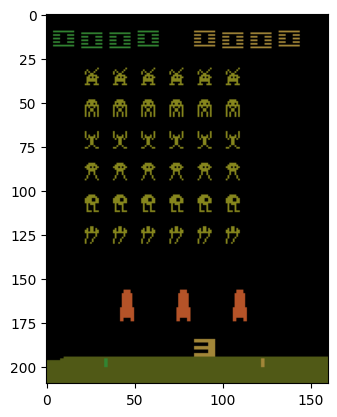

(210, 160, 3)


In [7]:
observation, info = env.reset(seed=42)
plt.imshow(observation)
plt.show()
print(observation.shape)

In [4]:
env = PreprocessImage(gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array'), width = 210, height = 160, grayscale = True) # render_mode="human"

In [5]:
observation, info = env.reset(seed=42)
done = False
img_array=[]

In [8]:
while not done:
    env.render() 
    #observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    # Feeding the game screen and getting the Q values for each action
    actions = CNN(Variable(Variable(torch.from_numpy(observation.reshape(1, 1, 210, 160)))))
    # Getting the action
    action = np.argmax(actions.detach().numpy(), axis=-1)
    # Now performing the action and moving to the next state, next_obs, receive reward
    observation, reward, terminated, truncated, info = env.step(action)
    img_array.append(observation)
    done = terminated or truncated
env.close()

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
